<a href="https://colab.research.google.com/github/ai-fast-track/timeseries/blob/master/nbs/cam_tutorial_ECG200.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial - 2: Model Interpretation for ECG200 Dataset
> CAM and GRAD-CAM for the ECG200 univariate time series dataset

In [ ]:
# Run this cell to install the latest version of fastai2 shared on github
!pip install git+https://github.com/fastai/fastai2.git

In [ ]:
# Run this cell to install the latest version of fastcore shared on github
!pip install git+https://github.com/fastai/fastcore.git

In [ ]:
# Run this cell to install the latest version of timeseries shared on github
!pip install git+https://github.com/ai-fast-track/timeseries.git

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.


In [ ]:
from fastai2.basics import *

In [ ]:
# hide
# Only for Windows users because symlink to `timeseries` folder is not recognized by Windows
import sys
sys.path.append("..")

In [ ]:
from timeseries.all import *

# Class Activation Map (CAM) and Grafient-CAM (GRAD-CAM) Tutorial
> Both CAM and GRAD-CAM allow producing ‘visual explanations’ on how a Convolutional Neural Network (CNN) model based its classification and therefore help interpreting the obtained results. The InceptionTime model is used as an illustration in this notebook.


## ECG Dataset
> This dataset was formatted by R. Olszewski as part of his thesis
“Generalized feature extraction for structural	pattern recognition
in time-series data,” at Carnegie Mellon University, 2001. Each
series traces the electrical activity recorded during one
heartbeat. The two classes are a normal heartbeat and a Myocardial
Infarction. Cardiac ischemia refers to lack of blood flow and oxygen to the heart muscle. If ischemia is severe or lasts too long, it can cause a heart attack (myocardial infarction) and can lead to heart tissue death. 	

![](images/ECG200.png)

## Training a model

In [ ]:
# You can choose any of univariate dataset listed the `data.py` file
path = unzip_data(URLs_TS.UNI_ECG200)

In [ ]:
dsname =  'ECG200' # 'GunPoint'
fname_train = f'{dsname}_TRAIN.arff'
fname_test = f'{dsname}_TEST.arff'
fnames = [path/fname_train, path/fname_test]
fnames

[Path('/home/farid/.fastai/data/ECG200/ECG200_TRAIN.arff'),
 Path('/home/farid/.fastai/data/ECG200/ECG200_TEST.arff')]

In [ ]:
# num_workers=0 is for Windows platform
dls = TSDataLoaders.from_files(bs=64,fnames=fnames, num_workers=0) 

In [ ]:
L(dls.splits[0]), L(dls.splits[1])

((#160) [66,176,14,106,71,193,95,16,133,113...],
 (#40) [142,56,198,77,50,55,4,69,174,47...])

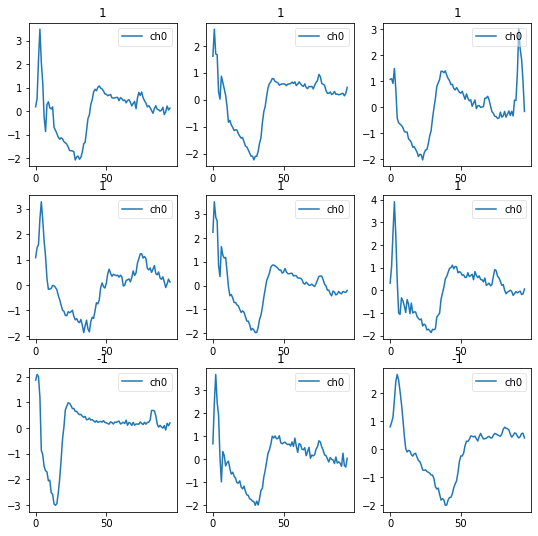

In [ ]:
dls.show_batch(chs=range(0,12,3))

In [ ]:
learn = ts_learner(dls)
learn.fit_one_cycle(25, lr_max=1e-3) 

epoch,train_loss,valid_loss,accuracy,time
0,1.514325,0.692650,0.575000,00:02
1,1.398919,0.693247,0.300000,00:01
2,1.240155,0.694572,0.425000,00:01
3,1.156367,0.695747,0.425000,00:01
4,1.015657,0.697076,0.425000,00:01
5,0.904095,0.700057,0.425000,00:01
6,0.821853,0.702071,0.425000,00:01
7,0.751845,0.703088,0.425000,00:01
8,0.694791,0.709002,0.425000,00:01
9,0.646897,0.709598,0.425000,00:01


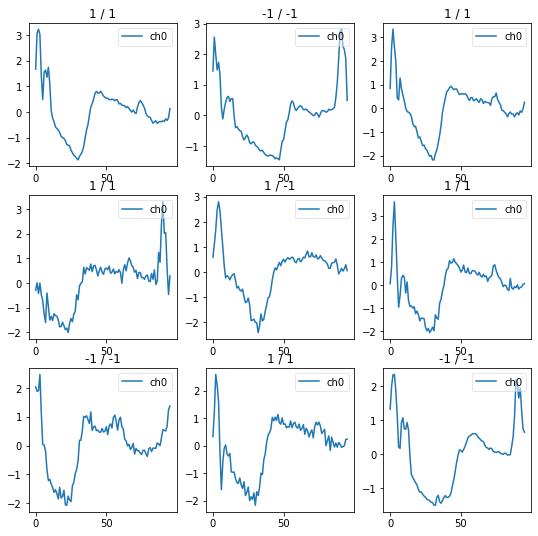

In [ ]:
learn.show_results()

In [ ]:
test_dl = dls.test_dl(dls.valid_ds.items[:4], with_labels=True)

In [ ]:
test_dl.dataset[3]

(TensorTS([[ 0.0688,  0.8088,  2.6080,  3.6403,  2.0933,  0.4260, -0.9568, -0.4517,
           0.2969,  0.4330,  0.3531, -0.3360,  0.1474, -0.6737, -0.9168, -0.9013,
          -0.9931, -0.9358, -1.2372, -1.1273, -1.2827, -1.5474, -1.4292, -1.4337,
          -1.4540, -1.8290, -1.9819, -1.8779, -2.0599, -1.9538, -1.8248, -1.9793,
          -1.2837, -1.4264, -1.4781, -0.7874, -0.6036, -0.2498, -0.0227,  0.3985,
           0.6798,  0.7384,  1.0780,  0.9663,  0.9901,  1.1602,  1.0158,  0.9428,
           0.8637,  0.7573,  0.5754,  0.6607,  0.8834,  0.5799,  0.5494,  0.7563,
           0.5278,  0.5052,  0.6278,  0.6424,  0.6113,  0.5101,  0.4449,  0.5677,
           0.4110,  0.3567,  0.4831,  0.3717,  0.4062,  0.1677,  0.3206,  0.3671,
           0.4476,  0.8420,  0.8972,  0.6475,  0.4743,  0.3365,  0.2815,  0.1232,
          -0.0576,  0.0104, -0.0179, -0.1763, -0.2338,  0.2968, -0.1090, -0.1694,
          -0.0557, -0.1052,  0.0186, -0.1623, -0.0896, -0.0720,  0.0387,  0.0765]]),
 TensorCate

In [ ]:
dls.vocab

(#2) ['-1','1']

In [ ]:
preds = learn.get_preds(dl=test_dl)  
preds

(tensor([[0.7731, 0.2269],
         [0.8335, 0.1665],
         [0.8674, 0.1326],
         [0.1509, 0.8491]]), tensor([0, 0, 0, 1]))

In [ ]:
for index, item in enumerate(preds[0]): 
	prediction = dls.categorize.decode(np.argmax(item)).upper() 
	confidence = max(item) 
	percent = float(confidence) 
	print(f"Prediction: {prediction} - Confidence: {percent*100:.2f}% - tserie = {test_dl.items[index][1]}")


Prediction: -1 - Confidence: 77.31% - tserie = -1
Prediction: -1 - Confidence: 83.35% - tserie = -1
Prediction: -1 - Confidence: 86.74% - tserie = -1
Prediction: 1 - Confidence: 84.91% - tserie = 1


In [ ]:
dls.loaders.append(test_dl)

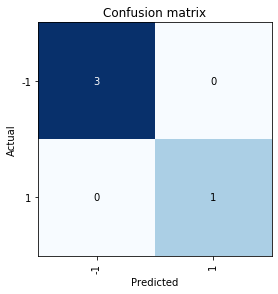

In [ ]:
interp = ClassificationInterpretation.from_learner(learn, ds_idx=2)
interp.plot_confusion_matrix()

In [ ]:
dls.valid_ds[0]

(TensorTS([[ 1.8736,  2.1874,  1.5088,  1.9780,  1.7962,  0.6774, -0.1484, -0.5396,
          -0.7587, -0.9018, -0.9599, -1.1773, -1.2501, -1.2607, -1.3765, -1.4355,
          -1.4462, -1.6237, -1.7887, -1.7263, -1.8446, -2.0626, -2.1496, -2.2455,
          -2.1873, -2.0864, -2.0077, -1.9566, -1.5772, -1.1743, -0.9572, -0.4957,
          -0.0488,  0.2134,  0.4389,  0.5379,  0.6609,  0.8858,  0.9189,  0.7721,
           0.7393,  0.9237,  0.7538,  0.6024,  0.6155,  0.6686,  0.8273,  0.5792,
           0.5323,  0.6763,  0.6367,  0.5580,  0.5122,  0.6179,  0.4937,  0.5959,
           0.5713,  0.2818,  0.4795,  0.4870,  0.4036,  0.3445,  0.4362,  0.3490,
           0.2668,  0.2423,  0.3568,  0.3239,  0.2124,  0.2893,  0.3630,  0.7108,
           0.8079,  0.6833,  0.6558,  0.5852,  0.5822,  0.3049,  0.1959,  0.1949,
           0.1820,  0.1120,  0.0448,  0.2385,  0.0729,  0.1748,  0.0955,  0.1349,
           0.1868,  0.0850,  0.2216,  0.0999,  0.1559,  0.1496,  0.0396,  0.2829]]),
 TensorCate

In [ ]:
dls.valid_ds[0:3]

[(TensorTS([[ 1.8736,  2.1874,  1.5088,  1.9780,  1.7962,  0.6774, -0.1484, -0.5396,
           -0.7587, -0.9018, -0.9599, -1.1773, -1.2501, -1.2607, -1.3765, -1.4355,
           -1.4462, -1.6237, -1.7887, -1.7263, -1.8446, -2.0626, -2.1496, -2.2455,
           -2.1873, -2.0864, -2.0077, -1.9566, -1.5772, -1.1743, -0.9572, -0.4957,
           -0.0488,  0.2134,  0.4389,  0.5379,  0.6609,  0.8858,  0.9189,  0.7721,
            0.7393,  0.9237,  0.7538,  0.6024,  0.6155,  0.6686,  0.8273,  0.5792,
            0.5323,  0.6763,  0.6367,  0.5580,  0.5122,  0.6179,  0.4937,  0.5959,
            0.5713,  0.2818,  0.4795,  0.4870,  0.4036,  0.3445,  0.4362,  0.3490,
            0.2668,  0.2423,  0.3568,  0.3239,  0.2124,  0.2893,  0.3630,  0.7108,
            0.8079,  0.6833,  0.6558,  0.5852,  0.5822,  0.3049,  0.1959,  0.1949,
            0.1820,  0.1120,  0.0448,  0.2385,  0.0729,  0.1748,  0.0955,  0.1349,
            0.1868,  0.0850,  0.2216,  0.0999,  0.1559,  0.1496,  0.0396,  0.2829]]),

In [ ]:
dls[0], dls.train, dls.train_ds

(<fastai2.data.core.TfmdDL at 0x7f1490c4d320>,
 (#160) [(TensorTS([[ 0.1646,  1.1073,  2.1470,  1.8764,  1.6426,  0.4217, -1.3479, -0.5744,
           0.3809, -0.1411, -0.0863,  0.2246, -0.2278, -0.8151, -1.0199, -1.1106,
          -1.1852, -1.3336, -1.1761, -1.2988, -1.5781, -1.5406, -1.6413, -1.5596,
          -1.6322, -1.8854, -1.8133, -1.8846, -1.9639, -2.0534, -2.0121, -1.9517,
          -1.9096, -1.7048, -1.3394, -1.2274, -0.9341, -0.4491, -0.2549, -0.1283,
           0.1780,  0.5129,  0.4291,  0.7831,  0.6607,  0.7724,  0.9404,  0.7366,
           0.7260,  0.6705,  0.7957,  0.6139,  0.5497,  0.7567,  0.5107,  0.5363,
           0.5037,  0.6803,  0.8794,  0.4919,  0.5064,  0.7127,  0.6011,  0.7105,
           0.6753,  0.5459,  0.6565,  0.5640,  0.5111,  0.5960,  0.4639,  0.5236,
           0.7882,  1.1295,  1.1495,  0.9823,  0.8940,  0.7642,  0.6859,  0.4138,
           0.3883,  0.6346,  0.3140,  0.2241,  0.4726,  0.1846,  0.3555,  0.2533,
           0.1191,  0.2962,  0.3221,  0.

## Export model

In [ ]:
learn.export()

In [ ]:
path = Path()
path.ls(file_exts='.pkl'), path

((#1) [Path('export.pkl')], Path('.'))

In [ ]:
learn_inf = load_learner(path/'export.pkl')

In [ ]:
test_dl = dls.test_dl(dls.valid_ds.items[:4], with_labels=True)

In [ ]:
items_samp_val = L(dls.valid.items)
# items_samp_val[0, 4]

In [ ]:
tseries = items_samp_val[0]
tseries

(array([[ 1.8736407 ,  2.1874466 ,  1.5087844 ,  1.9780172 ,  1.7962383 ,
          0.67738587, -0.14842977, -0.53957313, -0.7587289 , -0.90175486,
         -0.95987886, -1.1773249 , -1.2501404 , -1.2607268 , -1.3765078 ,
         -1.4355049 , -1.4462453 , -1.6237191 , -1.7887042 , -1.726299  ,
         -1.8446083 , -2.0626154 , -2.149623  , -2.245508  , -2.1872747 ,
         -2.0863683 , -2.0076897 , -1.9565567 , -1.5772268 , -1.174263  ,
         -0.95718384, -0.495672  , -0.04879091,  0.21336158,  0.4389171 ,
          0.5379448 ,  0.66087854,  0.8857814 ,  0.9189283 ,  0.7720663 ,
          0.7393265 ,  0.92372483,  0.7537786 ,  0.602403  ,  0.61545914,
          0.6686016 ,  0.82726854,  0.5791618 ,  0.5322523 ,  0.6763228 ,
          0.63666785,  0.55800134,  0.51224315,  0.6178619 ,  0.4937291 ,
          0.59587353,  0.57130986,  0.2817506 ,  0.47949255,  0.48696026,
          0.40362602,  0.34452182,  0.4362196 ,  0.3490221 ,  0.2667504 ,
          0.242295  ,  0.35680407,  0.

In [ ]:
pred = learn_inf.predict(tseries)
pred

('-1', tensor(0), tensor([0.8013, 0.1987]))

In [ ]:
dls.vocab

(#2) ['-1','1']

In [ ]:
i2o(pred[1])

'Normal'

In [ ]:
dls.valid.dataset.tls[1].tfms.vocab, dls.valid.dataset.tls[1].tfms.c

((#2) ['-1','1'], 2)

In [ ]:
test_items = items_samp_val[0, 4]
test_items

(#2) [(array([[ 1.8736407 ,  2.1874466 ,  1.5087844 ,  1.9780172 ,  1.7962383 ,
         0.67738587, -0.14842977, -0.53957313, -0.7587289 , -0.90175486,
        -0.95987886, -1.1773249 , -1.2501404 , -1.2607268 , -1.3765078 ,
        -1.4355049 , -1.4462453 , -1.6237191 , -1.7887042 , -1.726299  ,
        -1.8446083 , -2.0626154 , -2.149623  , -2.245508  , -2.1872747 ,
        -2.0863683 , -2.0076897 , -1.9565567 , -1.5772268 , -1.174263  ,
        -0.95718384, -0.495672  , -0.04879091,  0.21336158,  0.4389171 ,
         0.5379448 ,  0.66087854,  0.8857814 ,  0.9189283 ,  0.7720663 ,
         0.7393265 ,  0.92372483,  0.7537786 ,  0.602403  ,  0.61545914,
         0.6686016 ,  0.82726854,  0.5791618 ,  0.5322523 ,  0.6763228 ,
         0.63666785,  0.55800134,  0.51224315,  0.6178619 ,  0.4937291 ,
         0.59587353,  0.57130986,  0.2817506 ,  0.47949255,  0.48696026,
         0.40362602,  0.34452182,  0.4362196 ,  0.3490221 ,  0.2667504 ,
         0.242295  ,  0.35680407,  0.3238612

In [ ]:
test_tl = test_set(dls.valid.dataset, test_items)
test_tl

(#2) [(TensorTS([[ 1.8736,  2.1874,  1.5088,  1.9780,  1.7962,  0.6774, -0.1484, -0.5396,
         -0.7587, -0.9018, -0.9599, -1.1773, -1.2501, -1.2607, -1.3765, -1.4355,
         -1.4462, -1.6237, -1.7887, -1.7263, -1.8446, -2.0626, -2.1496, -2.2455,
         -2.1873, -2.0864, -2.0077, -1.9566, -1.5772, -1.1743, -0.9572, -0.4957,
         -0.0488,  0.2134,  0.4389,  0.5379,  0.6609,  0.8858,  0.9189,  0.7721,
          0.7393,  0.9237,  0.7538,  0.6024,  0.6155,  0.6686,  0.8273,  0.5792,
          0.5323,  0.6763,  0.6367,  0.5580,  0.5122,  0.6179,  0.4937,  0.5959,
          0.5713,  0.2818,  0.4795,  0.4870,  0.4036,  0.3445,  0.4362,  0.3490,
          0.2668,  0.2423,  0.3568,  0.3239,  0.2124,  0.2893,  0.3630,  0.7108,
          0.8079,  0.6833,  0.6558,  0.5852,  0.5822,  0.3049,  0.1959,  0.1949,
          0.1820,  0.1120,  0.0448,  0.2385,  0.0729,  0.1748,  0.0955,  0.1349,
          0.1868,  0.0850,  0.2216,  0.0999,  0.1559,  0.1496,  0.0396,  0.2829]]),),(TensorTS([[ 1.

In [ ]:
idxs = [0,2]
batch = get_batch(dls.train.dataset, idxs)
batch

(TensorTS([[[ 0.1646,  1.1073,  2.1470,  1.8764,  1.6426,  0.4217, -1.3479,
           -0.5744,  0.3809, -0.1411, -0.0863,  0.2246, -0.2278, -0.8151,
           -1.0199, -1.1106, -1.1852, -1.3336, -1.1761, -1.2988, -1.5781,
           -1.5406, -1.6413, -1.5596, -1.6322, -1.8854, -1.8133, -1.8846,
           -1.9639, -2.0534, -2.0121, -1.9517, -1.9096, -1.7048, -1.3394,
           -1.2274, -0.9341, -0.4491, -0.2549, -0.1283,  0.1780,  0.5129,
            0.4291,  0.7831,  0.6607,  0.7724,  0.9404,  0.7366,  0.7260,
            0.6705,  0.7957,  0.6139,  0.5497,  0.7567,  0.5107,  0.5363,
            0.5037,  0.6803,  0.8794,  0.4919,  0.5064,  0.7127,  0.6011,
            0.7105,  0.6753,  0.5459,  0.6565,  0.5640,  0.5111,  0.5960,
            0.4639,  0.5236,  0.7882,  1.1295,  1.1495,  0.9823,  0.8940,
            0.7642,  0.6859,  0.4138,  0.3883,  0.6346,  0.3140,  0.2241,
            0.4726,  0.1846,  0.3555,  0.2533,  0.1191,  0.2962,  0.3221,
            0.2635,  0.2045,  0.2107

In [ ]:
dec_targ, dec_pred, pred = learn_inf.get_preds(dl=[batch], with_decoded=True)
dec_targ, dec_pred, pred

(tensor([[0.2170, 0.7830],
         [0.9150, 0.0850]]), TensorCategory([1, 0]), tensor([1, 0]))

In [ ]:
batch[1]

TensorCategory([1, 0])

In [ ]:
my_pred = tensor([1, 1])
my_pred 

tensor([1, 1])

In [ ]:
my_pred_tc = TensorCategory(my_pred)
my_pred_tc

TensorCategory([1, 1])

In [ ]:
 L(batch[1])

(#1) [TensorCategory([1, 0])]

In [ ]:
new_b = (batch[0], dec_pred)
new_b

(TensorTS([[[ 0.1646,  1.1073,  2.1470,  1.8764,  1.6426,  0.4217, -1.3479,
           -0.5744,  0.3809, -0.1411, -0.0863,  0.2246, -0.2278, -0.8151,
           -1.0199, -1.1106, -1.1852, -1.3336, -1.1761, -1.2988, -1.5781,
           -1.5406, -1.6413, -1.5596, -1.6322, -1.8854, -1.8133, -1.8846,
           -1.9639, -2.0534, -2.0121, -1.9517, -1.9096, -1.7048, -1.3394,
           -1.2274, -0.9341, -0.4491, -0.2549, -0.1283,  0.1780,  0.5129,
            0.4291,  0.7831,  0.6607,  0.7724,  0.9404,  0.7366,  0.7260,
            0.6705,  0.7957,  0.6139,  0.5497,  0.7567,  0.5107,  0.5363,
            0.5037,  0.6803,  0.8794,  0.4919,  0.5064,  0.7127,  0.6011,
            0.7105,  0.6753,  0.5459,  0.6565,  0.5640,  0.5111,  0.5960,
            0.4639,  0.5236,  0.7882,  1.1295,  1.1495,  0.9823,  0.8940,
            0.7642,  0.6859,  0.4138,  0.3883,  0.6346,  0.3140,  0.2241,
            0.4726,  0.1846,  0.3555,  0.2533,  0.1191,  0.2962,  0.3221,
            0.2635,  0.2045,  0.2107

In [ ]:
dls.tfms

(#2) [Pipeline: itemgetter -> ToTensorTS,Pipeline: itemgetter -> Categorize]

In [ ]:
bb = dls.decode_batch(new_b)
bb

(#2) [(array([[ 0.16455767,  1.1072882 ,  2.146964  ,  1.8764232 ,  1.6426157 ,
         0.4217124 , -1.3478626 , -0.5743676 ,  0.38085118, -0.14112818,
        -0.08625106,  0.22459804, -0.22780341, -0.81511   , -1.019881  ,
        -1.110637  , -1.1851544 , -1.3335503 , -1.176131  , -1.2988095 ,
        -1.5780603 , -1.5405676 , -1.6413192 , -1.559647  , -1.6322386 ,
        -1.8853807 , -1.8132509 , -1.8846031 , -1.9639344 , -2.0534034 ,
        -2.0121174 , -1.951674  , -1.909618  , -1.704815  , -1.3393562 ,
        -1.2274244 , -0.93414897, -0.44911507, -0.25494182, -0.12825842,
         0.17804408,  0.5128517 ,  0.4290606 ,  0.7831202 ,  0.6607407 ,
         0.772361  ,  0.94044423,  0.73659176,  0.725984  ,  0.67048806,
         0.7956829 ,  0.61386603,  0.54969376,  0.7566785 ,  0.51065576,
         0.5362876 ,  0.5036684 ,  0.68026704,  0.87943906,  0.49186036,
         0.50644505,  0.7126966 ,  0.60107577,  0.7105194 ,  0.67531645,
         0.5458777 ,  0.65650296,  0.563967 

In [ ]:
tdl = dls.valid.new(bb, bs=2, num_workers=0)
tdl.to(default_device())
batch = tdl.one_batch()
batch

(tensor([[[ 0.1646,  1.1073,  2.1470,  1.8764,  1.6426,  0.4217, -1.3479,
           -0.5744,  0.3809, -0.1411, -0.0863,  0.2246, -0.2278, -0.8151,
           -1.0199, -1.1106, -1.1852, -1.3336, -1.1761, -1.2988, -1.5781,
           -1.5406, -1.6413, -1.5596, -1.6322, -1.8854, -1.8133, -1.8846,
           -1.9639, -2.0534, -2.0121, -1.9517, -1.9096, -1.7048, -1.3394,
           -1.2274, -0.9341, -0.4491, -0.2549, -0.1283,  0.1780,  0.5129,
            0.4291,  0.7831,  0.6607,  0.7724,  0.9404,  0.7366,  0.7260,
            0.6705,  0.7957,  0.6139,  0.5497,  0.7567,  0.5107,  0.5363,
            0.5037,  0.6803,  0.8794,  0.4919,  0.5064,  0.7127,  0.6011,
            0.7105,  0.6753,  0.5459,  0.6565,  0.5640,  0.5111,  0.5960,
            0.4639,  0.5236,  0.7882,  1.1295,  1.1495,  0.9823,  0.8940,
            0.7642,  0.6859,  0.4138,  0.3883,  0.6346,  0.3140,  0.2241,
            0.4726,  0.1846,  0.3555,  0.2533,  0.1191,  0.2962,  0.3221,
            0.2635,  0.2045,  0.2107, 

In [ ]:
# batch = get_batch(new_b, [0,1])
# batch

In [ ]:
# cat = Categorize(vocab=dls.vocab)
# cat.decodes(dec_pred[1])

In [ ]:
# tfm = ToTensorTS()
# tfm.decodes(batch[0][0])

In [ ]:
# items = [(item.numpy(), y.numpy().item()) for (item,y) in zip(batch[0], dec_pred)]
# items

In [ ]:
batch = get_batch(bb, [0,1])
batch

(tensor([[[ 0.1646,  1.1073,  2.1470,  1.8764,  1.6426,  0.4217, -1.3479,
           -0.5744,  0.3809, -0.1411, -0.0863,  0.2246, -0.2278, -0.8151,
           -1.0199, -1.1106, -1.1852, -1.3336, -1.1761, -1.2988, -1.5781,
           -1.5406, -1.6413, -1.5596, -1.6322, -1.8854, -1.8133, -1.8846,
           -1.9639, -2.0534, -2.0121, -1.9517, -1.9096, -1.7048, -1.3394,
           -1.2274, -0.9341, -0.4491, -0.2549, -0.1283,  0.1780,  0.5129,
            0.4291,  0.7831,  0.6607,  0.7724,  0.9404,  0.7366,  0.7260,
            0.6705,  0.7957,  0.6139,  0.5497,  0.7567,  0.5107,  0.5363,
            0.5037,  0.6803,  0.8794,  0.4919,  0.5064,  0.7127,  0.6011,
            0.7105,  0.6753,  0.5459,  0.6565,  0.5640,  0.5111,  0.5960,
            0.4639,  0.5236,  0.7882,  1.1295,  1.1495,  0.9823,  0.8940,
            0.7642,  0.6859,  0.4138,  0.3883,  0.6346,  0.3140,  0.2241,
            0.4726,  0.1846,  0.3555,  0.2533,  0.1191,  0.2962,  0.3221,
            0.2635,  0.2045,  0.2107, 

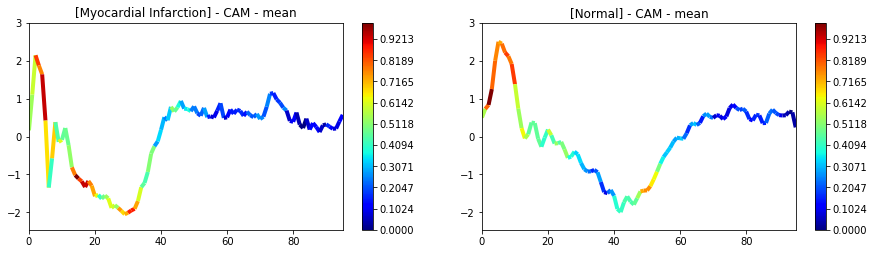

In [ ]:
show_cam(batch, model, layer=5, i2o=i2o, multi_fig=True, cmap=CMAP.jet) # default: func_cam=cam_acts, figsize=(13,4)

In [ ]:
tfm = ToTensor()
tfm.decodes(batch[0][0])

tensor([[ 0.1646,  1.1073,  2.1470,  1.8764,  1.6426,  0.4217, -1.3479, -0.5744,
          0.3809, -0.1411, -0.0863,  0.2246, -0.2278, -0.8151, -1.0199, -1.1106,
         -1.1852, -1.3336, -1.1761, -1.2988, -1.5781, -1.5406, -1.6413, -1.5596,
         -1.6322, -1.8854, -1.8133, -1.8846, -1.9639, -2.0534, -2.0121, -1.9517,
         -1.9096, -1.7048, -1.3394, -1.2274, -0.9341, -0.4491, -0.2549, -0.1283,
          0.1780,  0.5129,  0.4291,  0.7831,  0.6607,  0.7724,  0.9404,  0.7366,
          0.7260,  0.6705,  0.7957,  0.6139,  0.5497,  0.7567,  0.5107,  0.5363,
          0.5037,  0.6803,  0.8794,  0.4919,  0.5064,  0.7127,  0.6011,  0.7105,
          0.6753,  0.5459,  0.6565,  0.5640,  0.5111,  0.5960,  0.4639,  0.5236,
          0.7882,  1.1295,  1.1495,  0.9823,  0.8940,  0.7642,  0.6859,  0.4138,
          0.3883,  0.6346,  0.3140,  0.2241,  0.4726,  0.1846,  0.3555,  0.2533,
          0.1191,  0.2962,  0.3221,  0.2635,  0.2045,  0.2107,  0.3972,  0.5730]])

In [ ]:
batch[0][0]

tensor([[ 0.1646,  1.1073,  2.1470,  1.8764,  1.6426,  0.4217, -1.3479, -0.5744,
          0.3809, -0.1411, -0.0863,  0.2246, -0.2278, -0.8151, -1.0199, -1.1106,
         -1.1852, -1.3336, -1.1761, -1.2988, -1.5781, -1.5406, -1.6413, -1.5596,
         -1.6322, -1.8854, -1.8133, -1.8846, -1.9639, -2.0534, -2.0121, -1.9517,
         -1.9096, -1.7048, -1.3394, -1.2274, -0.9341, -0.4491, -0.2549, -0.1283,
          0.1780,  0.5129,  0.4291,  0.7831,  0.6607,  0.7724,  0.9404,  0.7366,
          0.7260,  0.6705,  0.7957,  0.6139,  0.5497,  0.7567,  0.5107,  0.5363,
          0.5037,  0.6803,  0.8794,  0.4919,  0.5064,  0.7127,  0.6011,  0.7105,
          0.6753,  0.5459,  0.6565,  0.5640,  0.5111,  0.5960,  0.4639,  0.5236,
          0.7882,  1.1295,  1.1495,  0.9823,  0.8940,  0.7642,  0.6859,  0.4138,
          0.3883,  0.6346,  0.3140,  0.2241,  0.4726,  0.1846,  0.3555,  0.2533,
          0.1191,  0.2962,  0.3221,  0.2635,  0.2045,  0.2107,  0.3972,  0.5730]])

In [ ]:
items = dls[0].decode_batch((batch[0],dec_pred))
items

(#2) [(TensorTS([[ 0.1646,  1.1073,  2.1470,  1.8764,  1.6426,  0.4217, -1.3479, -0.5744,
          0.3809, -0.1411, -0.0863,  0.2246, -0.2278, -0.8151, -1.0199, -1.1106,
         -1.1852, -1.3336, -1.1761, -1.2988, -1.5781, -1.5406, -1.6413, -1.5596,
         -1.6322, -1.8854, -1.8133, -1.8846, -1.9639, -2.0534, -2.0121, -1.9517,
         -1.9096, -1.7048, -1.3394, -1.2274, -0.9341, -0.4491, -0.2549, -0.1283,
          0.1780,  0.5129,  0.4291,  0.7831,  0.6607,  0.7724,  0.9404,  0.7366,
          0.7260,  0.6705,  0.7957,  0.6139,  0.5497,  0.7567,  0.5107,  0.5363,
          0.5037,  0.6803,  0.8794,  0.4919,  0.5064,  0.7127,  0.6011,  0.7105,
          0.6753,  0.5459,  0.6565,  0.5640,  0.5111,  0.5960,  0.4639,  0.5236,
          0.7882,  1.1295,  1.1495,  0.9823,  0.8940,  0.7642,  0.6859,  0.4138,
          0.3883,  0.6346,  0.3140,  0.2241,  0.4726,  0.1846,  0.3555,  0.2533,
          0.1191,  0.2962,  0.3221,  0.2635,  0.2045,  0.2107,  0.3972,  0.5730]]), '1'),(TensorTS([

In [ ]:
tdl = TfmdDL(new_b, bs=2, num_workers=0)
tdl.to(default_device())
batch_pred = tdl.one_batch()
batch_pred

RuntimeError: Expected object of scalar type Float but got scalar type Long for sequence element 1 in sequence argument at position #1 'tensors'

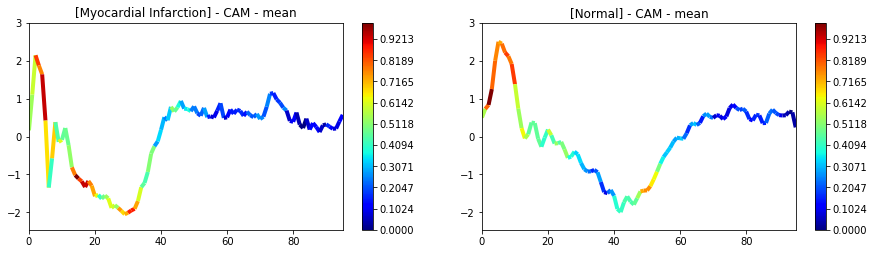

In [ ]:
show_cam(batch, model, layer=5, i2o=i2o, multi_fig=True, cmap=CMAP.jet) # default: func_cam=cam_acts, figsize=(13,4)

In [ ]:
pred_tup = [tuplify(p) for p in dec_pred]
pred_tup

[(tensor(1),), (tensor(0),)]

In [ ]:
batch[0]

TensorTS([[[ 0.1646,  1.1073,  2.1470,  1.8764,  1.6426,  0.4217, -1.3479,
          -0.5744,  0.3809, -0.1411, -0.0863,  0.2246, -0.2278, -0.8151,
          -1.0199, -1.1106, -1.1852, -1.3336, -1.1761, -1.2988, -1.5781,
          -1.5406, -1.6413, -1.5596, -1.6322, -1.8854, -1.8133, -1.8846,
          -1.9639, -2.0534, -2.0121, -1.9517, -1.9096, -1.7048, -1.3394,
          -1.2274, -0.9341, -0.4491, -0.2549, -0.1283,  0.1780,  0.5129,
           0.4291,  0.7831,  0.6607,  0.7724,  0.9404,  0.7366,  0.7260,
           0.6705,  0.7957,  0.6139,  0.5497,  0.7567,  0.5107,  0.5363,
           0.5037,  0.6803,  0.8794,  0.4919,  0.5064,  0.7127,  0.6011,
           0.7105,  0.6753,  0.5459,  0.6565,  0.5640,  0.5111,  0.5960,
           0.4639,  0.5236,  0.7882,  1.1295,  1.1495,  0.9823,  0.8940,
           0.7642,  0.6859,  0.4138,  0.3883,  0.6346,  0.3140,  0.2241,
           0.4726,  0.1846,  0.3555,  0.2533,  0.1191,  0.2962,  0.3221,
           0.2635,  0.2045,  0.2107,  0.3972,  0.

In [ ]:
batch[1]

TensorCategory([1, 0])

In [ ]:
# def show_results(x:TensorTS, y, samples, outs, ctxs=None, max_n=9, nrows=None, ncols=None, figsize=None, **kwargs)
show_results(batch[0], batch[1], batch[0], pred_tup)

AttributeError: 'Tensor' object has no attribute 'show'

## Get Model

In [ ]:
model = learn.model.eval()

In [ ]:
model[5]

SequentialEx(
  (layers): ModuleList(
    (0): InceptionModule(
      (bottleneck): Conv1d(128, 32, kernel_size=(1,), stride=(1,))
      (convs): ModuleList(
        (0): Conv1d(32, 32, kernel_size=(39,), stride=(1,), padding=(19,), bias=False)
        (1): Conv1d(32, 32, kernel_size=(19,), stride=(1,), padding=(9,), bias=False)
        (2): Conv1d(32, 32, kernel_size=(9,), stride=(1,), padding=(4,), bias=False)
      )
      (maxpool_bottleneck): Sequential(
        (0): MaxPool1d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
        (1): Conv1d(128, 32, kernel_size=(1,), stride=(1,), bias=False)
      )
      (bn_relu): Sequential(
        (0): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU()
      )
    )
    (1): Shortcut(
      (act_fn): ReLU(inplace=True)
      (conv): Conv1d(128, 128, kernel_size=(1,), stride=(1,), bias=False)
      (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_st

In [ ]:
dls.vocab

(#2) ['-1','1']

## Decoding class labels 

In [ ]:
# i2o() function
# Converting CategoryTensor label into the human-readable label
lbl_dict = dict([
    (0, 'Normal'),   
    (1, 'Myocardial Infarction')]
)
def i2o(y):
    return lbl_dict.__getitem__(y.data.item())
    # return lbl_dict.__getitem__(int(dls.tfms[1][1].decodes(y)))

## Creating a customized batch :  list of 2 items 

> Note: This is not a batch in literal sense as used using `DataLoader.one_batch()` method. It just a list of some dataset items
- batch\[0\]: corresponds to `Normal ECG`
- batch\[1\]: corresponds to `Myocardial Infarction`

In [ ]:
idxs = [0,2]
batch = get_batch(dls.train.dataset, idxs)

## Plotting CAM for several dataset items in one shared figure 
> Example: the function expects a list of `items` and plots CAM for the provided items list.

### Class Activation Map (CAM)
This option calculates the activations values at the selected layer.By default the activations curves are plotted in one single figure.

`func_cam=cam_acts` : activation function name (activation values at the chosen model layer). It is the default value
 
The figure title `[Myocardial Infarction - Normal] - CAM - mean` should be read as follow:
- `Myocardial Infarction`     : class of the first curve
- `Normal`   : class of the second curve
- `CAM`     : activation function name (activation values at the chosen model layer)
- `mean`    : type of reduction (read the explanation below: 4 types of reductions)

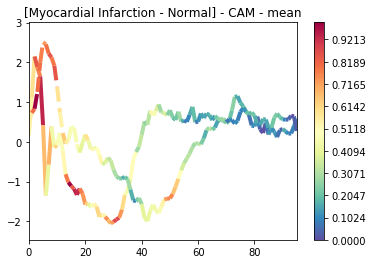

In [ ]:
show_cam(batch, model, layer=5, i2o=i2o, func_cam=cam_acts) # default:  func_cam=cam_acts, multi_fig=False, figsize=(6,4)

### Plot each time series curve in a separate figure  

### Using CAM and `CMAP.seismic` palette

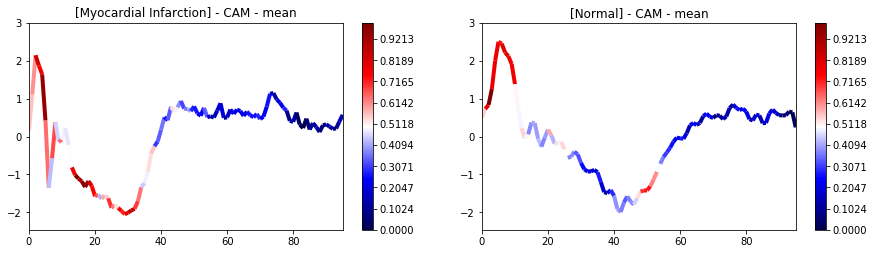

In [ ]:
show_cam(batch, model, layer=5, i2o=i2o, multi_fig=True, cmap=CMAP.seismic) # default: func_cam=cam_acts, figsize=(13,4)

### Using GRAD-CAM and `CMAP.seismic` palette
> Notice the difference in activations values between CAM and GRAD-CAM

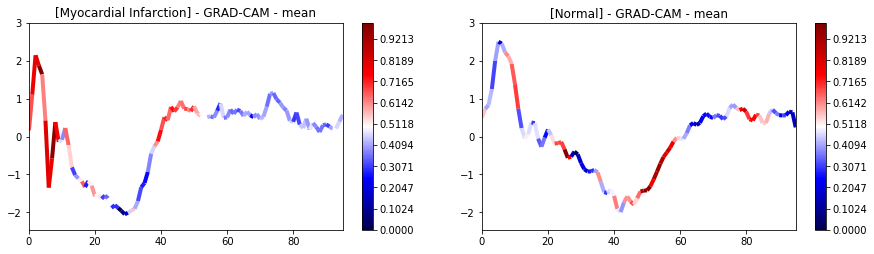

In [ ]:
show_cam(batch, model, layer=5, i2o=i2o, func_cam=grad_cam_acts, multi_fig=True, cmap=CMAP.seismic) 

### Superimposed curves give another insight in comparing the 2 time series

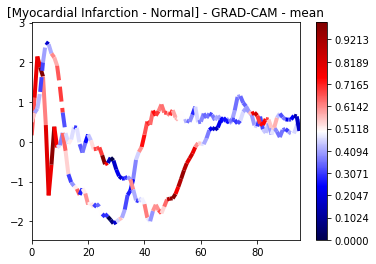

In [ ]:
show_cam(batch, model, layer=5, i2o=i2o, func_cam=grad_cam_acts, cmap=CMAP.seismic)

### Plotting scattered lines

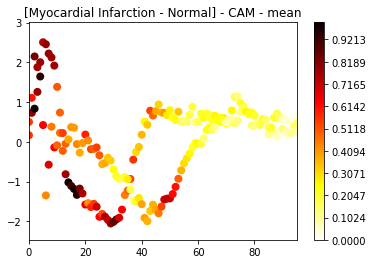

In [ ]:
show_cam(batch, model, layer=5, i2o=i2o, linewidth=2, scatter=True, cmap=CMAP.hot_r)

## Plotting CAM for a batch of items 
> We can also feed the show_cam() a full batch return straight from `DataLoaders` `one_batch() method as shown here below

### Creating a batch of 5 items

In [ ]:
dls.train = dls.train.new(bs=5)
batch = dls.train.one_batch()
# batch

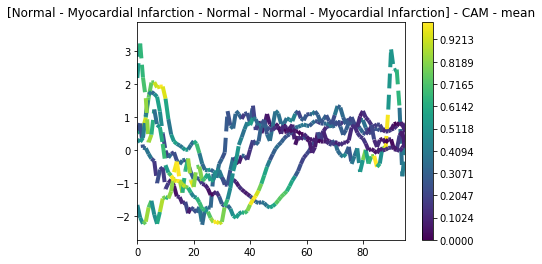

In [ ]:
show_cam(batch, model, layer=5, i2o=i2o, cmap=CMAP.viridis)

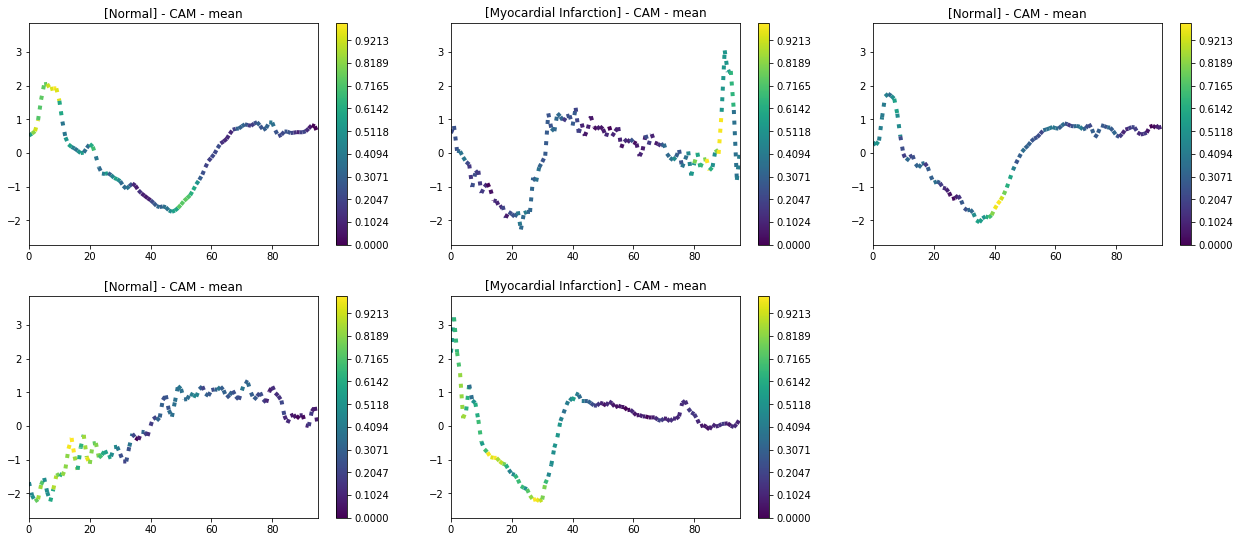

In [ ]:
show_cam(batch, model, layer=5, i2o=i2o, cmap=CMAP.viridis, multi_fig=True, figsize=(18, 8), linestyles='dotted')

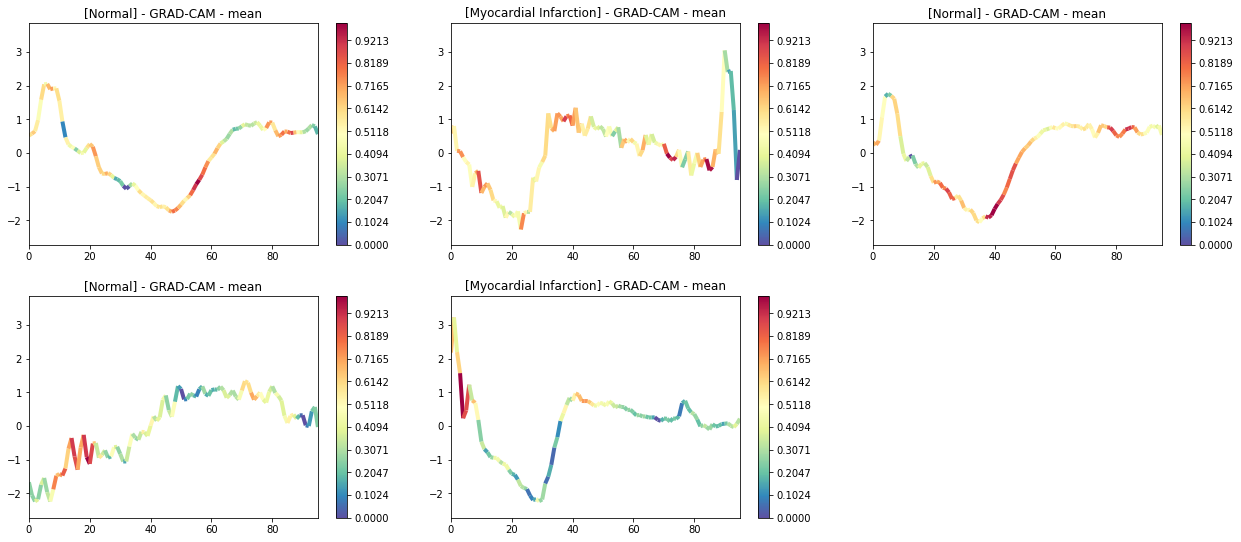

In [ ]:
show_cam(batch, model, layer=5, i2o=i2o, func_cam=grad_cam_acts, multi_fig=True, figsize=(18, 8))

## Plotting CAM for a single dataset item 

> We can also feed the `show_cam()` a single item

> There are also `164` different palettes. Check out `CMAP` class and its autocompletion

> line styles : 'solid' | 'dashed' | 'dashdot' | 'dotted'


In [ ]:
idxs = [0]
batch = get_batch(dls.train.dataset, idxs)

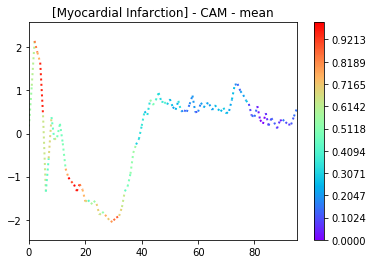

In [ ]:
show_cam(batch, model, layer=5, i2o=i2o, cmap='rainbow', linewidth=2, linestyles='dotted')

![](images/montreal-pont-jacques-cartier.jpg)
